# (28751) Eggl orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)
import matplotlib.pyplot as plt

In [3]:
body_id = '28751'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = 0.0
de_kernel = 441
de_kernel_path = grss.utils.default_kernel_path(de_kernel)

In [4]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias = False
debias_lowres = True
deweight = True
eliminate = False
max_obs_per_night = 4
verbose = True
obs_array_optical, observer_codes_optical = fit.get_mpc_optical_obs_array(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias, debias_lowres, deweight, eliminate, max_obs_per_night, verbose)
obs_array_radar, observer_codes_radar = fit.get_radar_obs_array(body_id, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    obs_array_gaia, observer_codes_gaia = fit.get_gaia_optical_obs_array(body_id, de_kernel_path, t_min_tdb=None, t_max_tdb=None, verbose=True)
    obs_array_optical = np.vstack((obs_array_optical, obs_array_gaia))
    observer_codes_optical = observer_codes_optical + observer_codes_gaia

Skipped 0 observations 
	 0 of which were non-geocentric occultations or space-based observations, 
	 0 were either roving or radar observations (radar is handled separately), 
	 0 of which were outside the specified time range.
No debiasing needed for 521 observations. Debiased 900 observations. No biasing information for 6 observations.
Applied default weight of 1 arcsec to 67 CCD observations
Deweighted 331 observations as part of deweighting scheme.
Found 169 observations from Gaia DR3.
	 Added 21 of those observations.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, init_cov, obs_array_optical, observer_codes_optical, obs_array_radar, observer_codes_radar, n_iter_max=n_iter_max, de_kernel=de_kernel, de_kernel_path=de_kernel_path, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.417			 0.527			 784.354			 0.271
2			 0.417			 0.527			 783.730			 0.271
Converged without rejecting outliers. Starting outlier rejection now.
3			 0.412			 0.511			 733.107			 0.254
4			 0.412			 0.511			 733.018			 0.254
Converged after rejecting outliers.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 4 (of 4):
RMS unweighted: 0.41243245624162866
RMS weighted: 0.5105078971809847
chi-squared: 733.0184580602538
reduced chi-squared: 0.254167287815622
square root of reduced chi-squared: 0.5041500647779608
t: MJD 57677.0 TDB
Fitted Variable		Initial Value			Uncertainty			Fitted Value 			Uncertainty			Change				Change (sigma)
e			1.13396432914e-01		1.27800041908e-08 		1.13396430039e-01		1.26712218820e-08 		-2.87498437557e-09		-0.225
q			2.23476404725e+00		3.33004611652e-08 		2.23476405482e+00		3.29862322224e-08 		+7.57590390421e-09		+0.228
tp			5.79392319939e+04		2.57307598942e-05 		5.79392319980e+04		2.57640803107e-05 		+4.03701415053e-06		+0.157
om			2.76279148598e+02		1.60843188009e-05 		2.76279148984e+02		1.60590572948e-05 		+3.86205442737e-07		+0.024
w			4.93285360211e+01		1.60260169337e-05 		4.93285363067e+01		1.60479354165e-05 		+2.85616621909e-07		+0.018
i			1.74609955155e+00		4.22811877452e-07 		1.74609953318e+00		4.22897439780e-

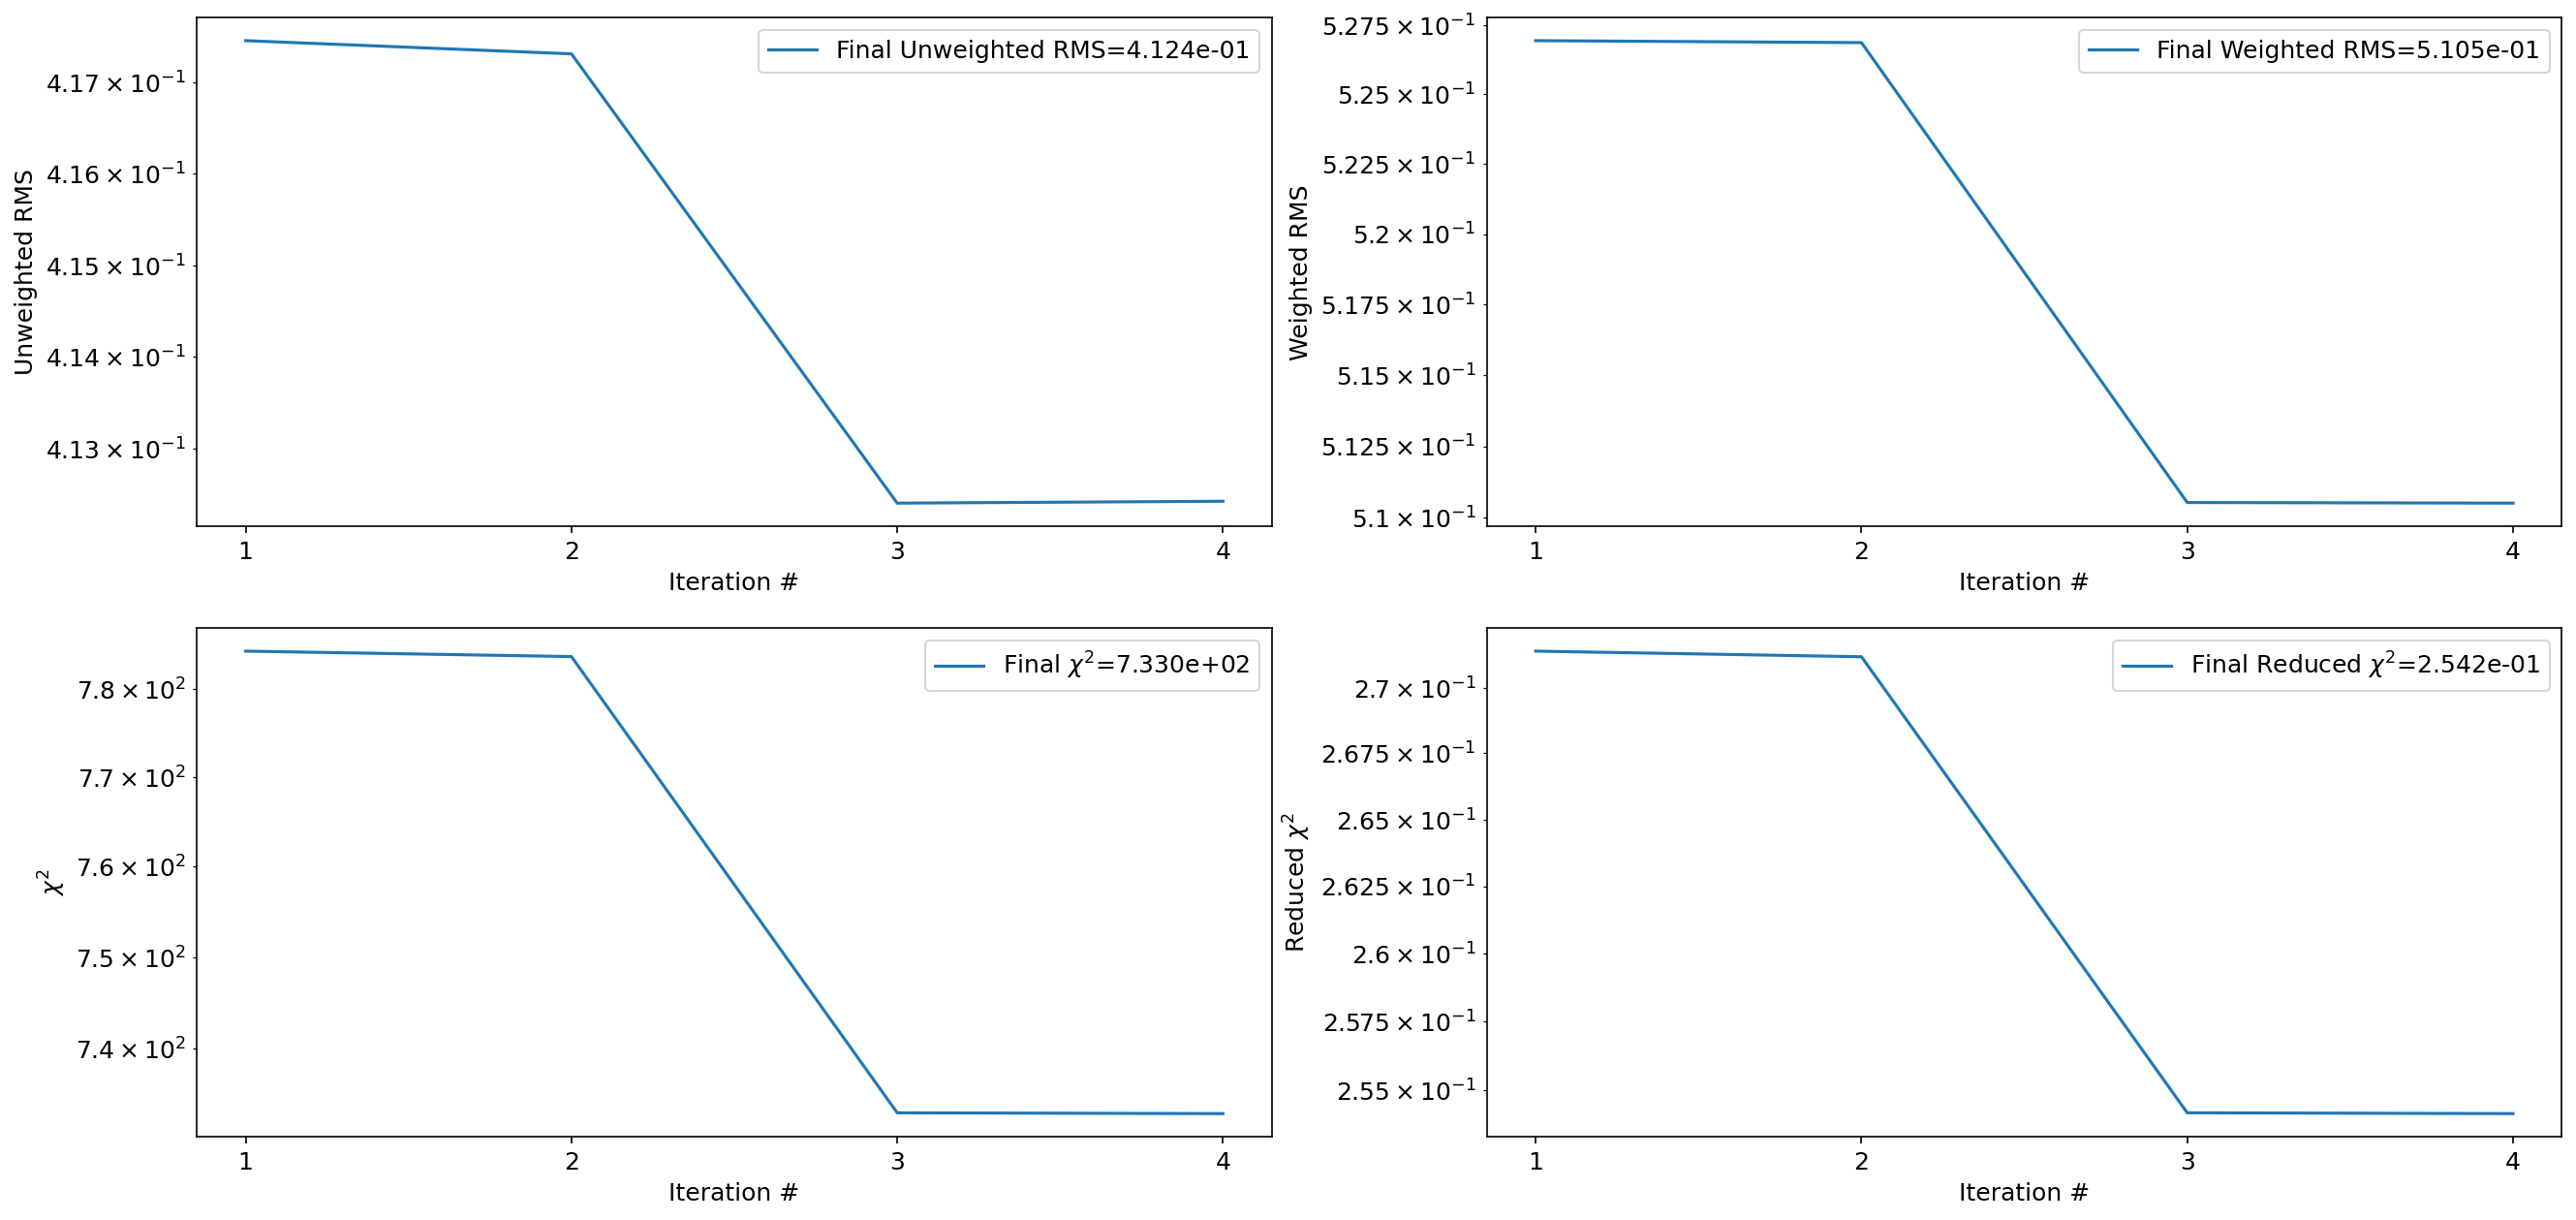

In [8]:
fit_sim.plot_summary(auto_close=True)

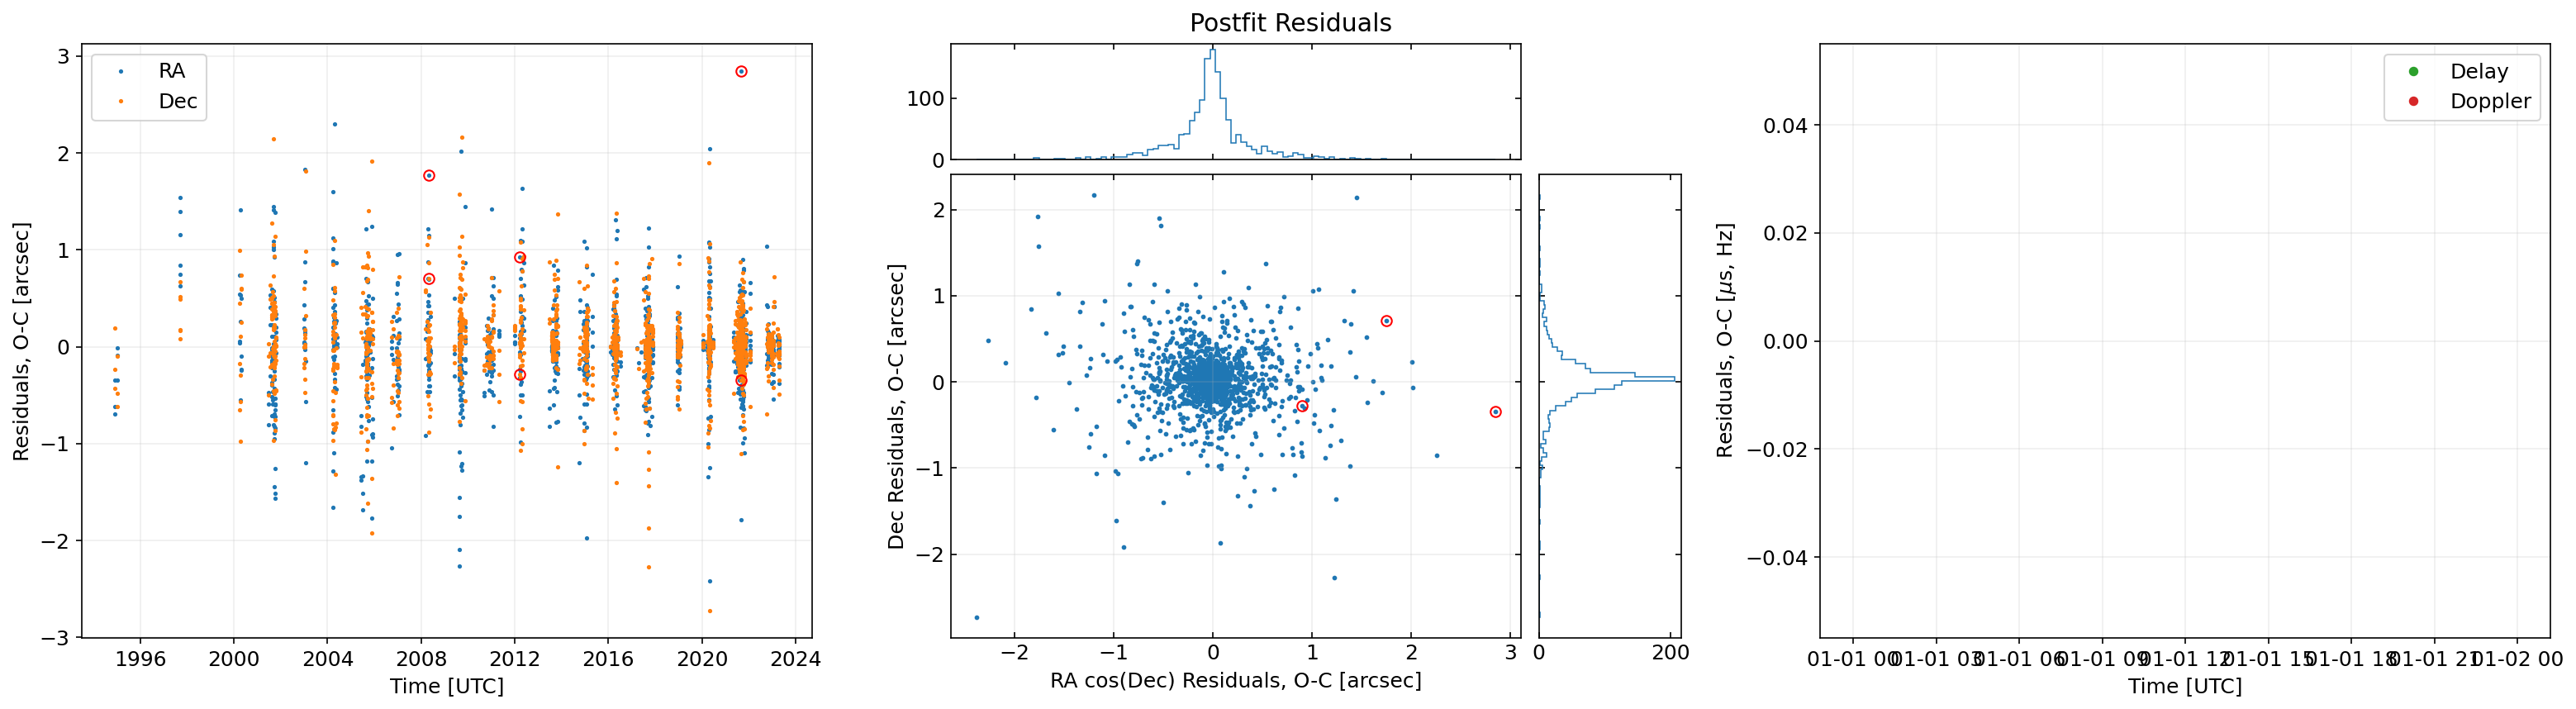

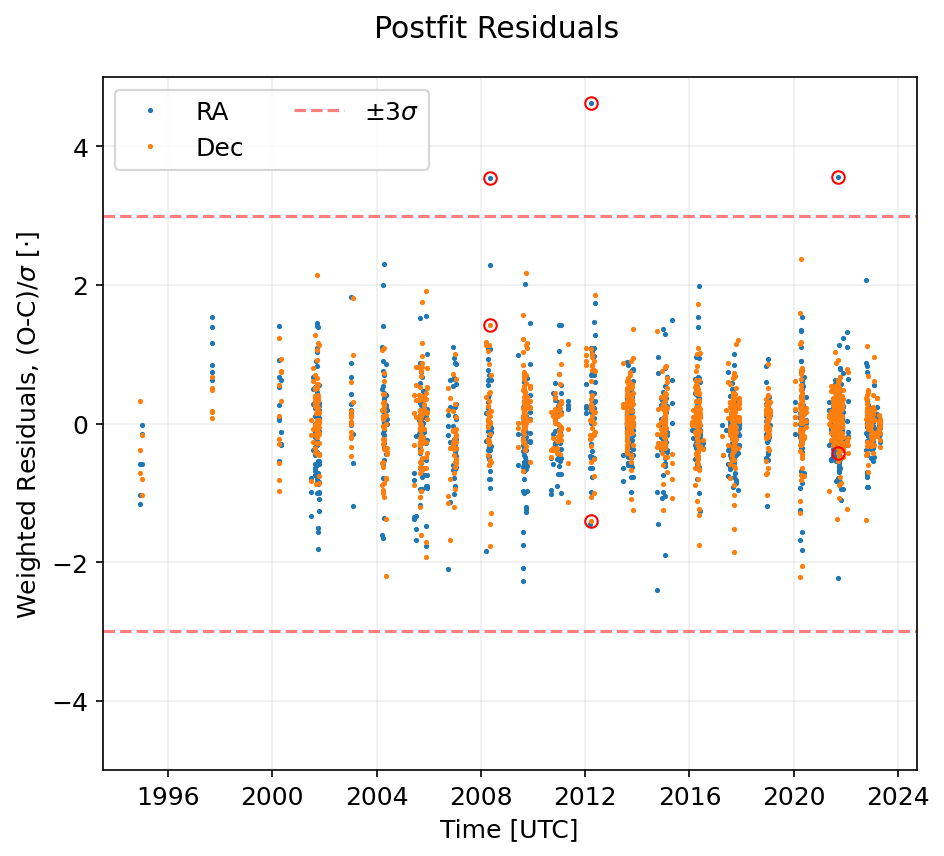

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 0.38
Mahalonobis distance between GRSS and JPL solution: 0.37
Bhattacharya distance between JPL and GRSS solution: 0.0001
Bhattacharya coefficient between JPL and GRSS solution: 0.9999


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90